In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle

In [2]:
plt.style.use('plot_style-Examples.txt')

In [3]:
from scipy import io
import numpy as np

import matplotlib.pyplot as plt


from sklearn.gaussian_process import GaussianProcessRegressor

from sklearn.gaussian_process.kernels import Matern, RBF, ConstantKernel, WhiteKernel


from scipy.linalg import cholesky, cho_factor, cho_solve

import scipy

In [4]:
def get_data(filename, ndata):
    # 5->85x85, 6->71x71, 7->61x61, 10->43x43, 12->36x36, 14->31x31, 15->29x29
    r = 15
    s = int(((421 - 1) / r) + 1)

    # Data is of the shape (number of samples = 1024, grid size = 421x421)
    data = io.loadmat(filename)
    x_branch = data["coeff"][:ndata, ::r, ::r].astype(np.float64) * 0.1 - 0.75
    y = data["sol"][:ndata, ::r, ::r].astype(np.float64) * 100
    # The dataset has a mistake that the BC is not 0.
    y[:, 0, :] = 0
    y[:, -1, :] = 0
    y[:, :, 0] = 0
    y[:, :, -1] = 0

    grids = []
    grids.append(np.linspace(0, 1, s, dtype=np.float32))
    grids.append(np.linspace(0, 1, s, dtype=np.float32))
    grid = np.vstack([xx.ravel() for xx in np.meshgrid(*grids)]).T

    x_branch = x_branch.reshape(ndata, s * s)
    #x = (x_branch, grid)
    y = y.reshape(ndata, s * s)
    return x_branch, y, grid


x, y, grid = get_data("piececonst_r421_N1024_smooth1.mat", 1000)
x_test, y_test, grid = get_data("piececonst_r421_N1024_smooth2.mat", 200)

In [5]:
idx = 20
##coef = x_test[idx].reshape(29,29)
#sol = y_test[idx].reshape(29,29)
Input2D = x_test[idx].reshape(29,29)
Output2D = y_test[idx].reshape(29,29)

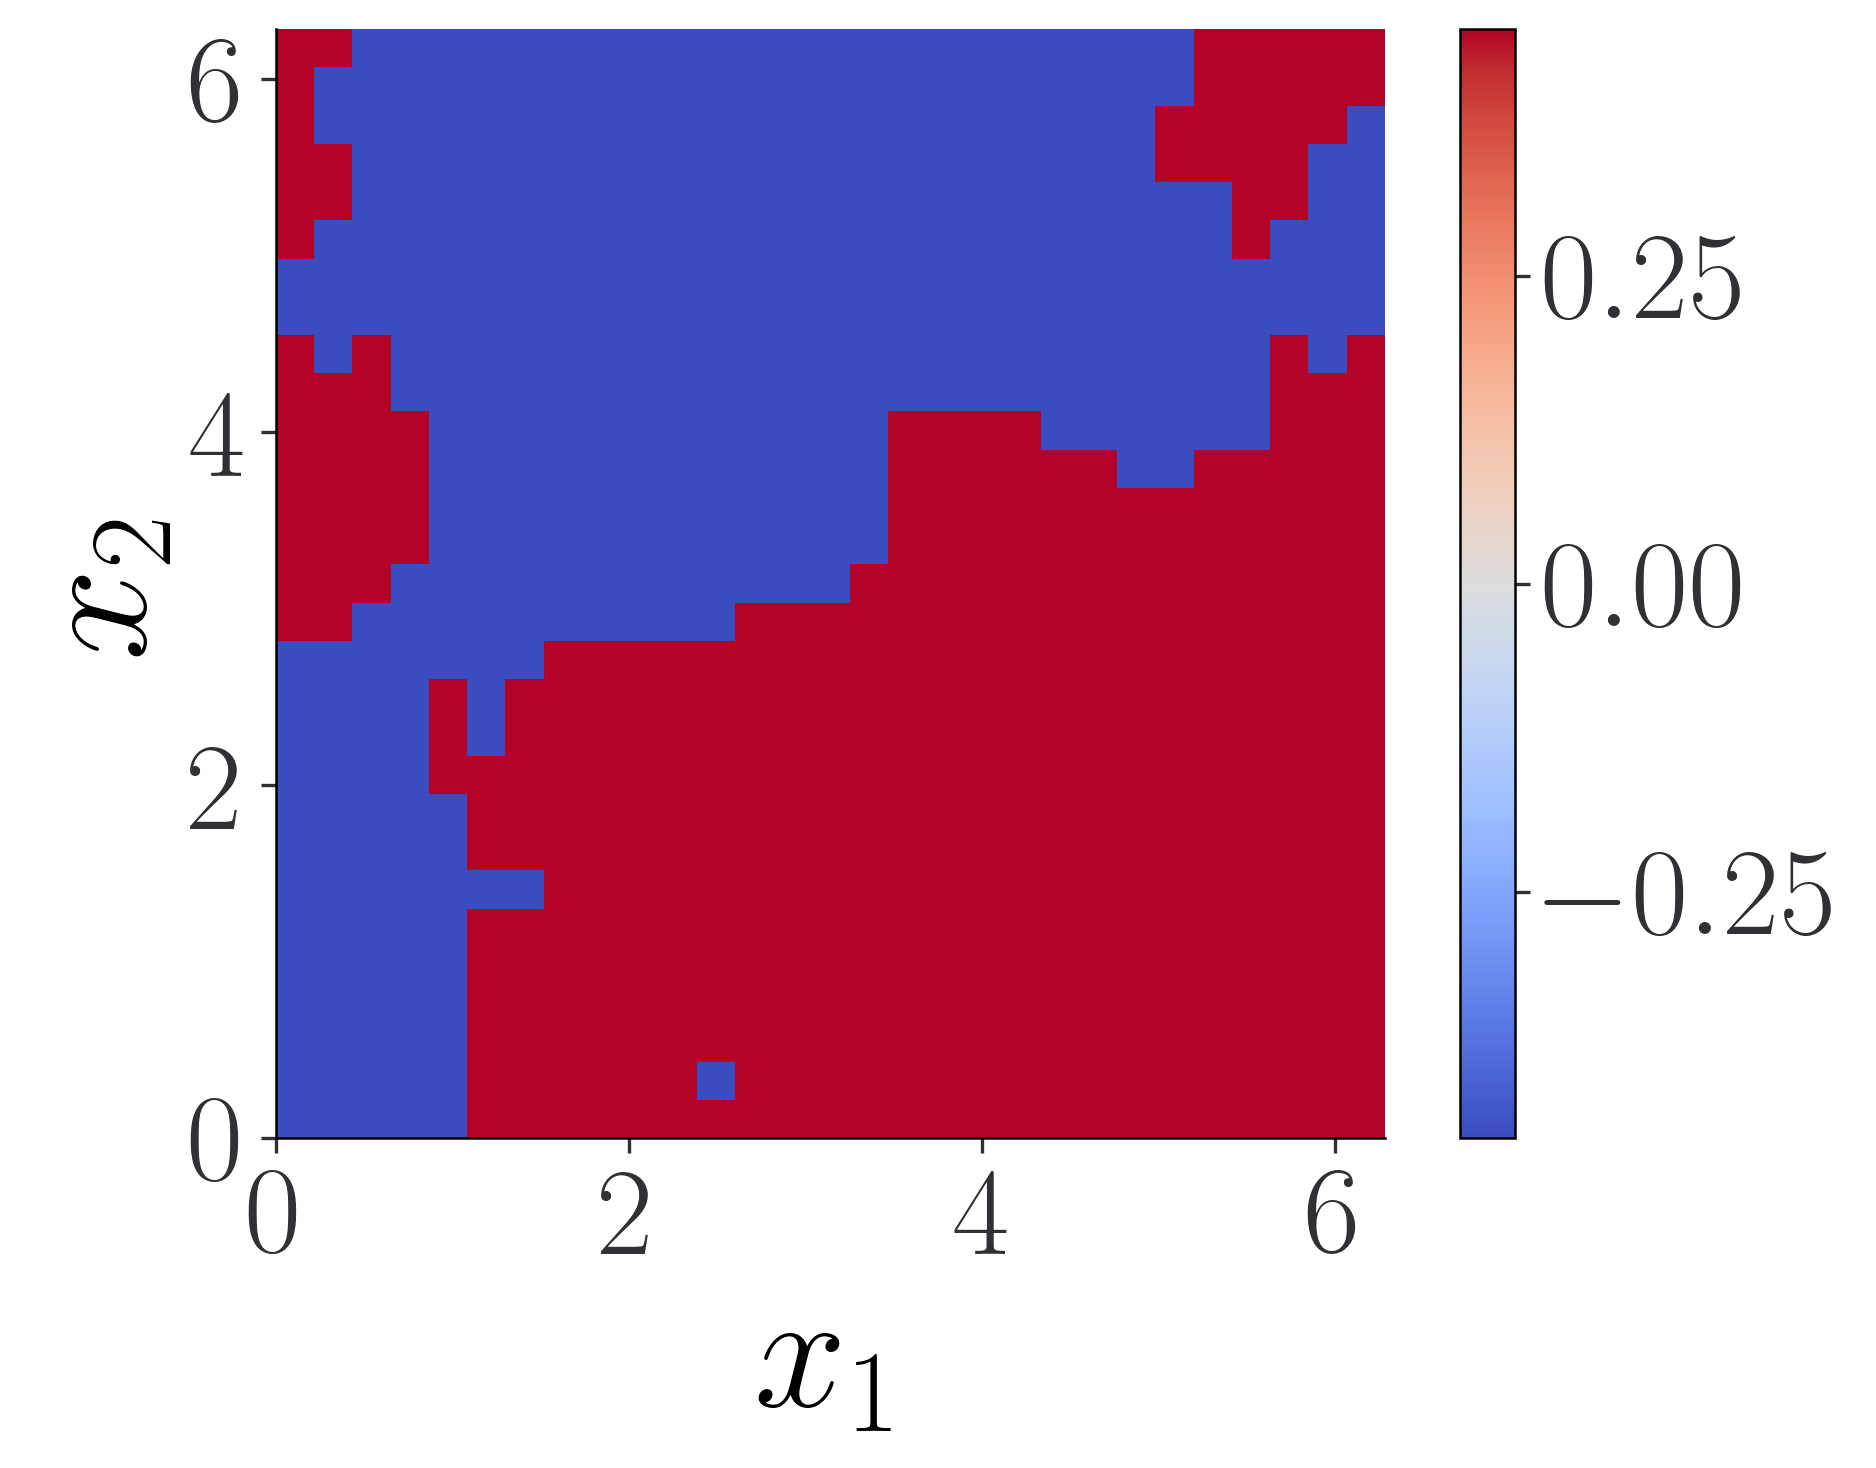

In [27]:
fig, ax = plt.subplots(1,1)
ax.set_xlabel(r'$x_1$')
#fig.suptitle(r'Input, Navier Stokes')
ax.set_ylabel(r'$x_2$')
s = ax.imshow(Input2D, extent=(0,2*np.pi,0,2*np.pi), origin = 'lower')
#ax.set_xticks([0, 3, 5])
c = fig.colorbar(s)
ax.set_xticks([0, 2, 4, 6])
plt.savefig('InputDarcy.pdf',  bbox_inches = 'tight')

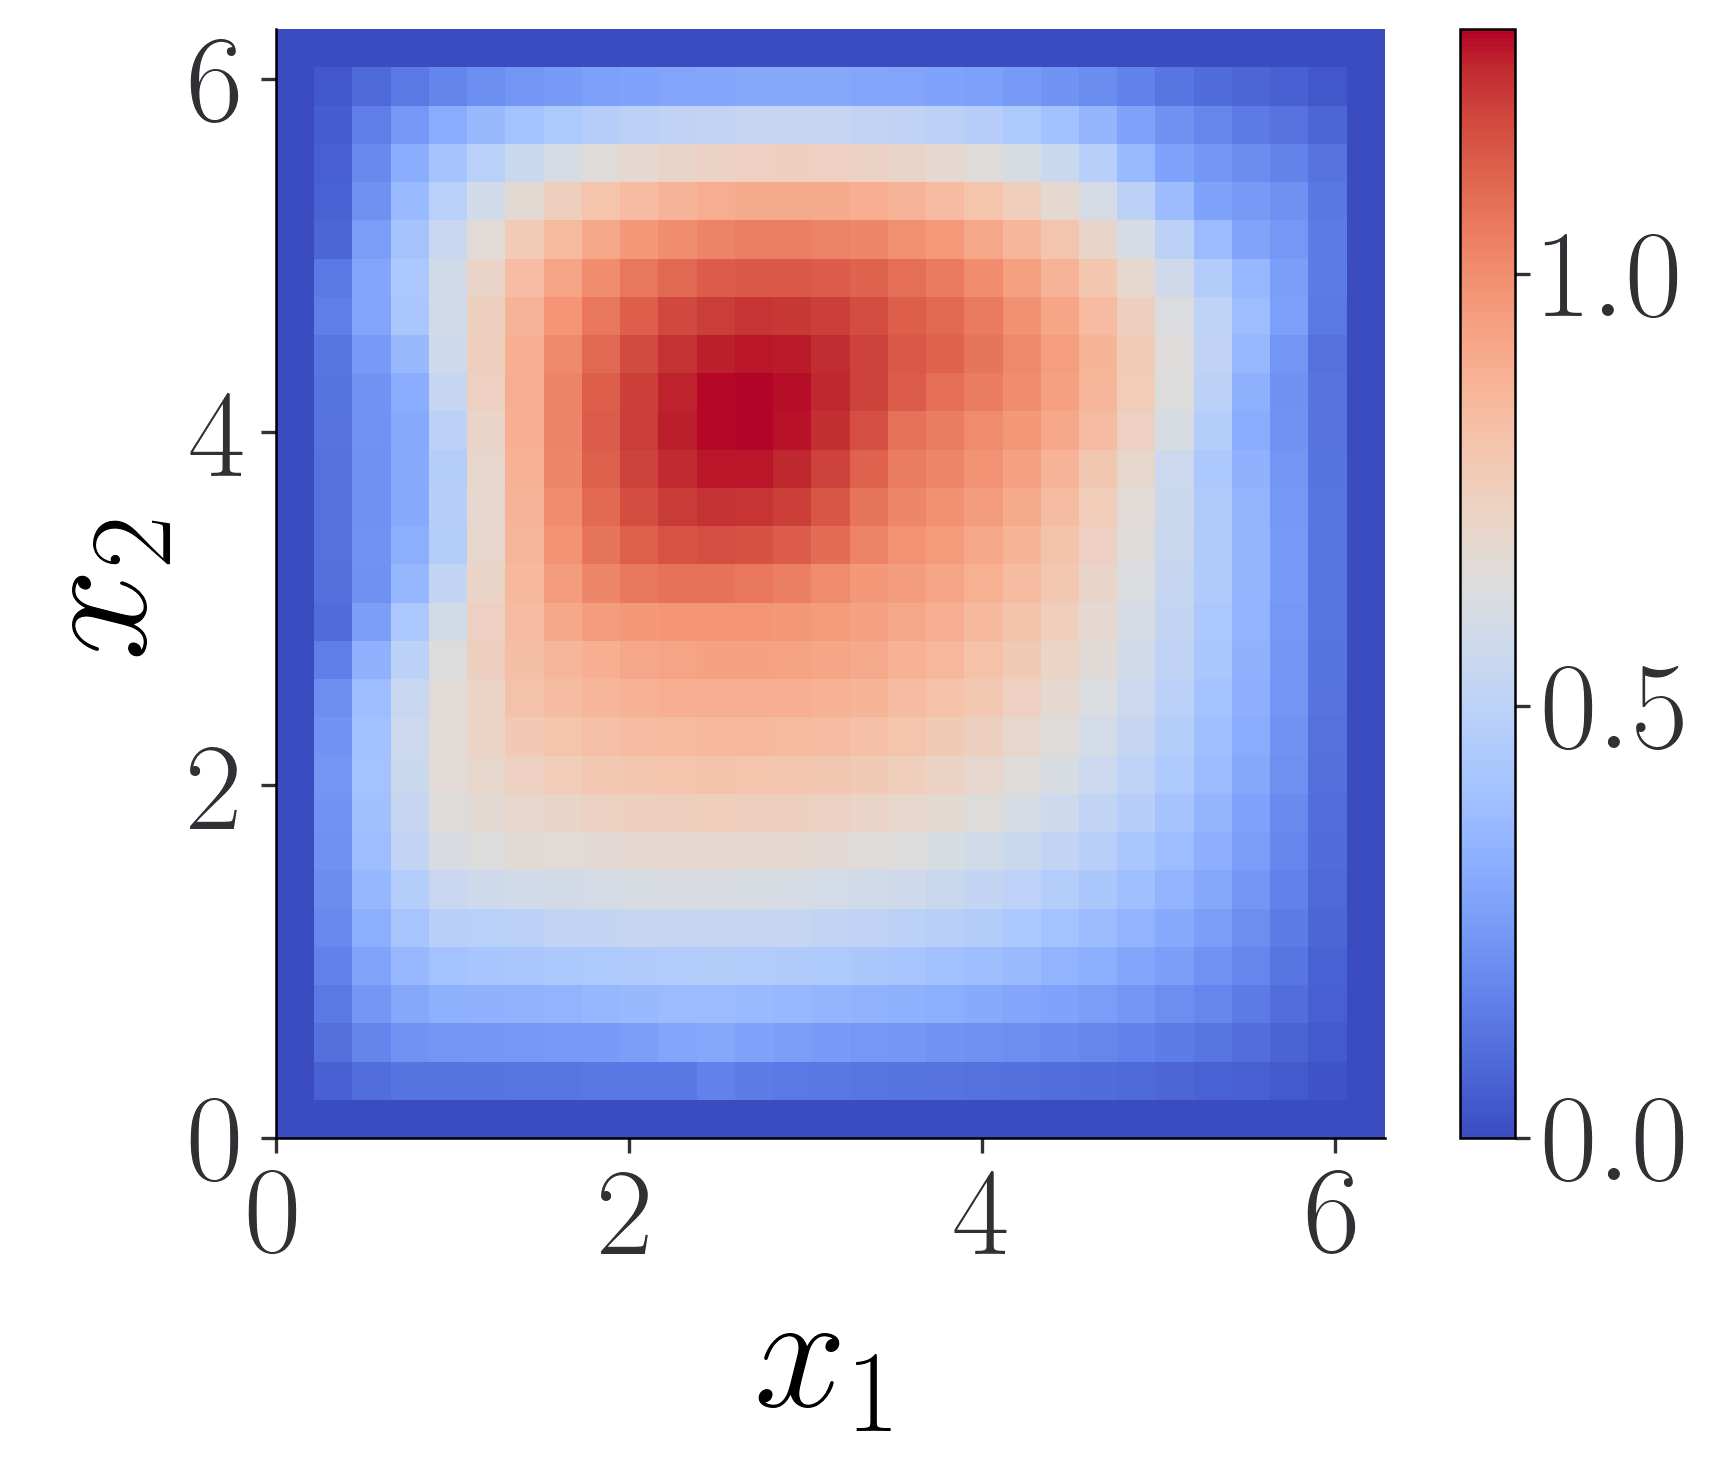

In [28]:
fig, ax = plt.subplots(1,1)
ax.set_xlabel(r'$x_1$')
#fig.suptitle(r'Input, Navier Stokes')
ax.set_ylabel(r'$x_2$')
s = ax.imshow(Output2D, extent=(0,2*np.pi,0,2*np.pi), origin = 'lower')
#ax.set_xticks([0, 2.5, 5])
ax.set_xticks([0, 2, 4, 6])
c = fig.colorbar(s)
plt.savefig('OutputDarcy.pdf',  bbox_inches = 'tight')

In [8]:
def compute_cho(kernel_u, kernel_v, grid):
    K = kernel_u(grid)
    G = kernel_v(grid)
    #print(np.linalg.cond(K))

    tau = 1e-8
    L_K = cholesky(K + tau*np.eye(K.shape[0]), lower=True)
    G_inv = np.linalg.inv(G + tau*np.eye(G.shape[0]))   
    L_G = cholesky(G_inv+ tau*np.eye(G.shape[0]), lower = True)
    
    return L_K, L_G

def precondition(L_K, L_G, u ,v):
    tau = 1e-8
    L_G_inv = L_G
    return (L_K.T @ u[:, :, None]).squeeze(-1), (L_G_inv.T @ v[:, :, None]).squeeze(-1)
    
    
def compute_error(prediction, target):
    e = np.mean(np.linalg.norm(prediction - target, axis = -1)/np.linalg.norm(target, axis = -1))
    
    return e

def optimal_recovery(K, G, L_K, L_G, u, v):
    tau = 0
    #L_K_inv = np.linalg.inv(L_K + tau*np.eye(K.shape[0]))
    L_G_inv = L_G #np.linalg.inv(L_G + tau*np.eye(K.shape[0]))
    
    u = np.linalg.solve(L_K.T, u[:, :, None]).squeeze(-1)
    #u_recov = np.squeeze(K@scipy.linalg.cho_solve((L_K, True), u[None] ))
    u_recov = np.squeeze(K@scipy.linalg.solve(K, u.T, assume_a = 'pos' )).T
    v_recov = np.squeeze(G@L_G_inv@v[:, :, None])
    
    return u_recov, v_recov
    

In [9]:
def train_test(x_train, x_test, y_train, y_test):
    kernel = Matern(nu = 1.5, length_scale = 1.0)
    gp = GaussianProcessRegressor(kernel, alpha = 1e-10,  normalize_y = False, random_state= 6032023) 
    
    gp.fit(x_train, y_train)
    pred= gp.predict(x_test)
    #pred_train = gp.predict(x_train)

    #e = compute_error_dataset(y_test, pred, knots, k)

    return pred, gp

In [10]:
kernel_u =Matern(nu = 0.5, length_scale = 0.06867071982701294) 
kernel_v = Matern(nu = 0.5, length_scale = 0.1)

kernel_v = WhiteKernel()

L_K, L_G = compute_cho(kernel_u, kernel_v, grid)

x_train, y_train = precondition(L_K, L_G, x, y)
x_val, y_val = precondition(L_K, L_G, x_test, y_test)


pred, gp = train_test(x_train, x_val, y_train, y_val)
pred_train = gp.predict(x_train)

e = compute_error(pred, y_val)
e_train = compute_error(pred_train, y_train)
print(e, e_train)

0.028066780351621957 8.177786556354613e-09


In [11]:
# pointwise prediction
K = kernel_u(grid)
G = kernel_v(grid)
_, pred_train_point = optimal_recovery(K, G, L_K, L_G, x_train, pred_train)
_, pred_point = optimal_recovery(K, G, L_K, L_G, x_val, pred)

e = compute_error(pred_point, y_test)
e_train = compute_error(pred_train_point, y)
print(e, e_train)

0.028066780351621957 8.177786556354613e-09


In [12]:
np.allclose(pred, pred_point) 

True

In [13]:
#pred_train = y_train
#pred = y_val
# pointwise prediction
K = kernel_u(grid)
G = kernel_v(grid)
_, pred_train_point = optimal_recovery(K, G, L_K, L_G, x_train, pred_train)
_, pred_point = optimal_recovery(K, G, L_K, L_G, x_val, pred)

e = compute_error(pred_point, y_test)
e_train = compute_error(pred_train_point, y)
print(e, e_train)

0.028066780351621957 8.177786556354613e-09


In [14]:
idx = 101

y_true = y_test[idx].reshape(29,29)
y_pred = pred[idx].reshape(29,29)

diff = np.sqrt((y_true - y_pred)**2/(y_true)**2)

#diff = np.abs(y_true - y_pred)

/tmp/ipykernel_12213/1153367908.py:6: RuntimeWarning: invalid value encountered in true_divide
  diff = np.sqrt((y_true - y_pred)**2/(y_true)**2)


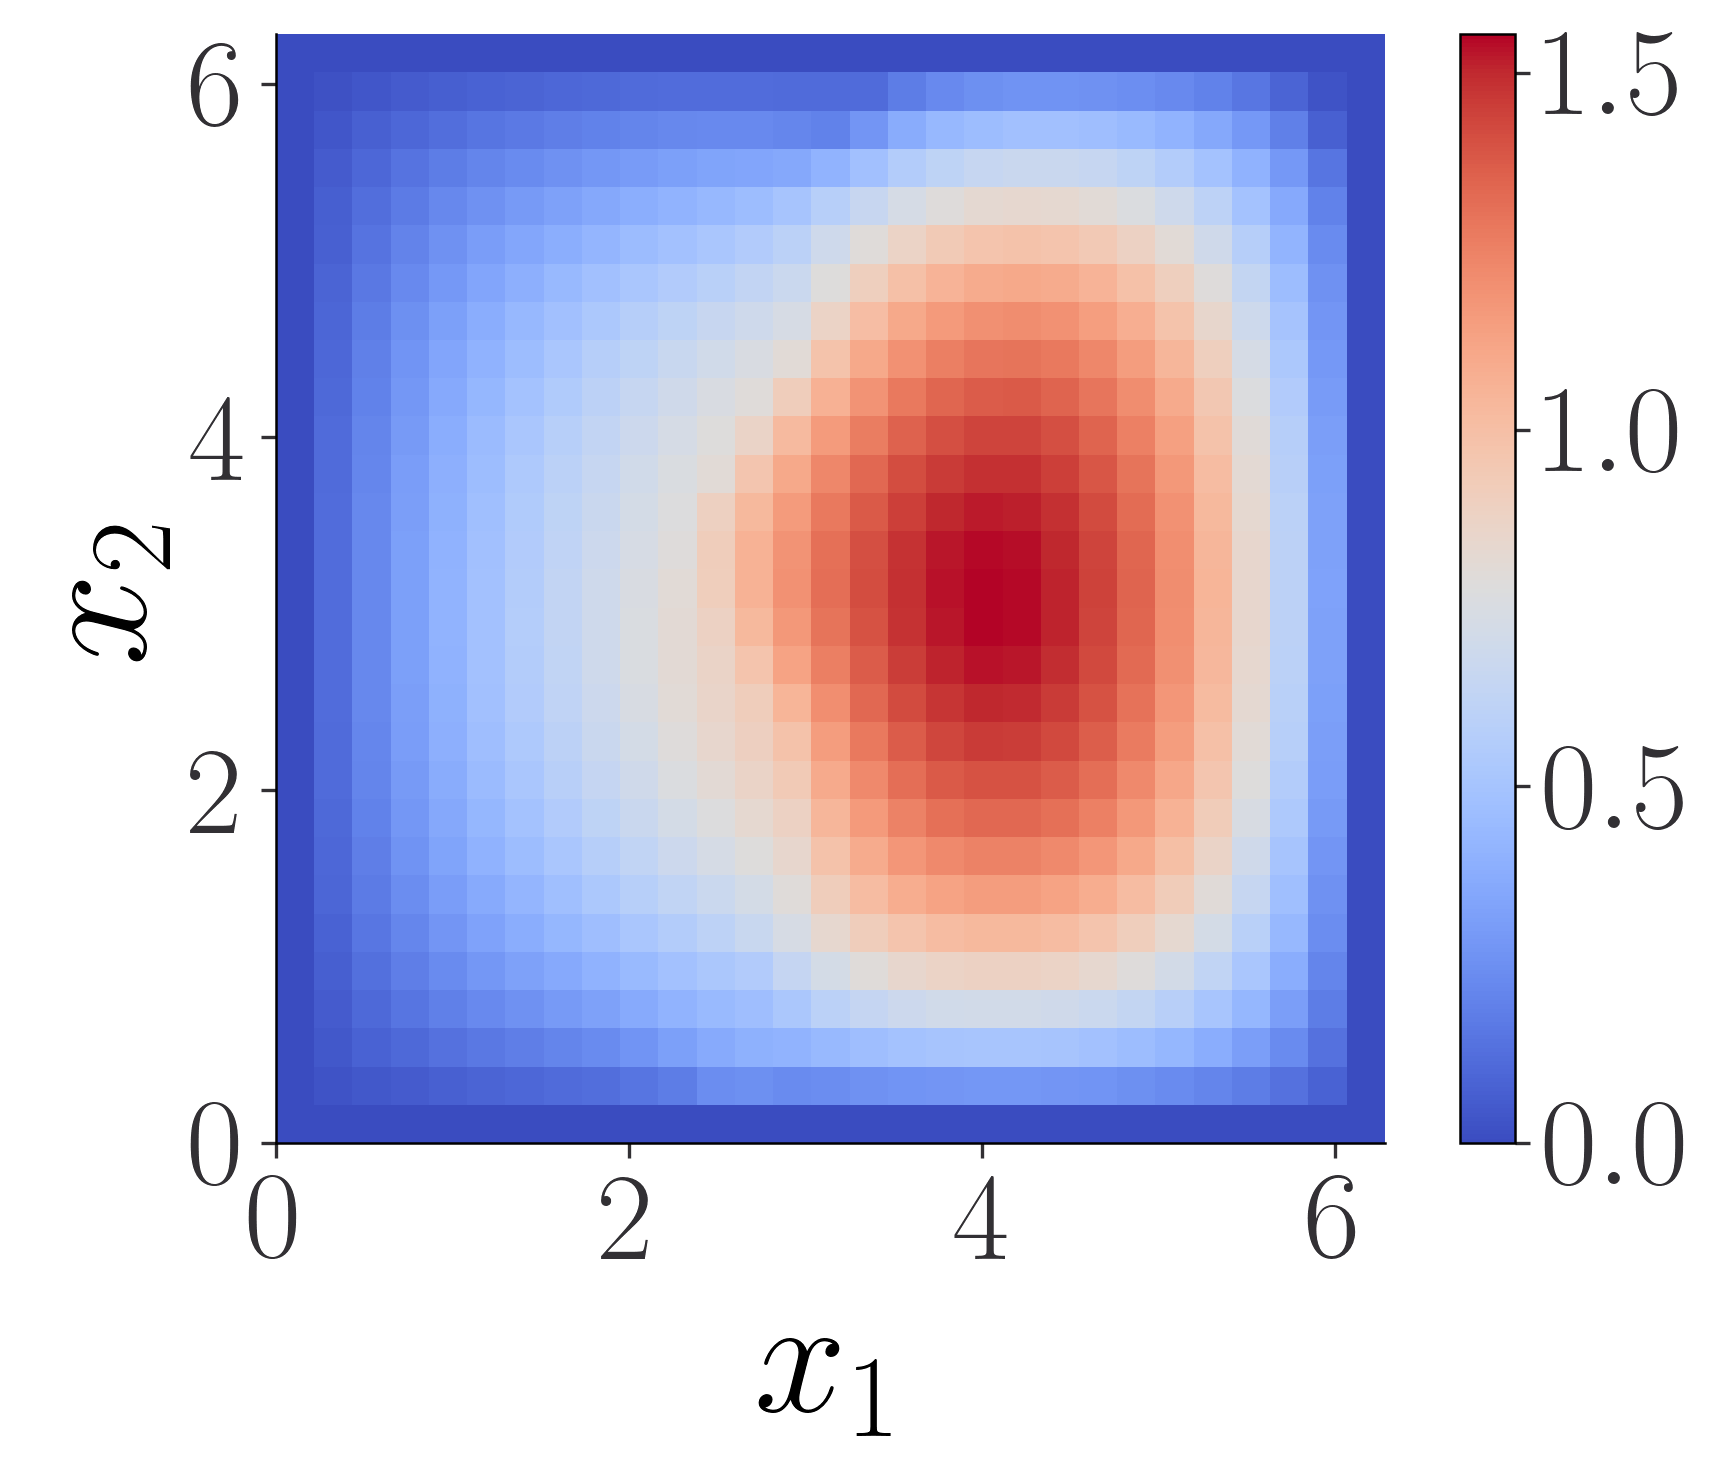

In [25]:
fig, ax = plt.subplots(1,1)
ax.set_xlabel(r'$x_1$')
#fig.suptitle(r'Input, Navier Stokes')
ax.set_ylabel(r'$x_2$')
s = ax.imshow(y_true, extent=(0,2*np.pi,0,2*np.pi), origin = 'lower')
#ax.set_xticks([0, 2.5, 5])
ax.set_xticks([0, 2, 4, 6])
c = fig.colorbar(s)
#c.set_ticks([-0.05, 0, 0.05])
plt.savefig('TrueDarcy.pdf',  bbox_inches = 'tight')

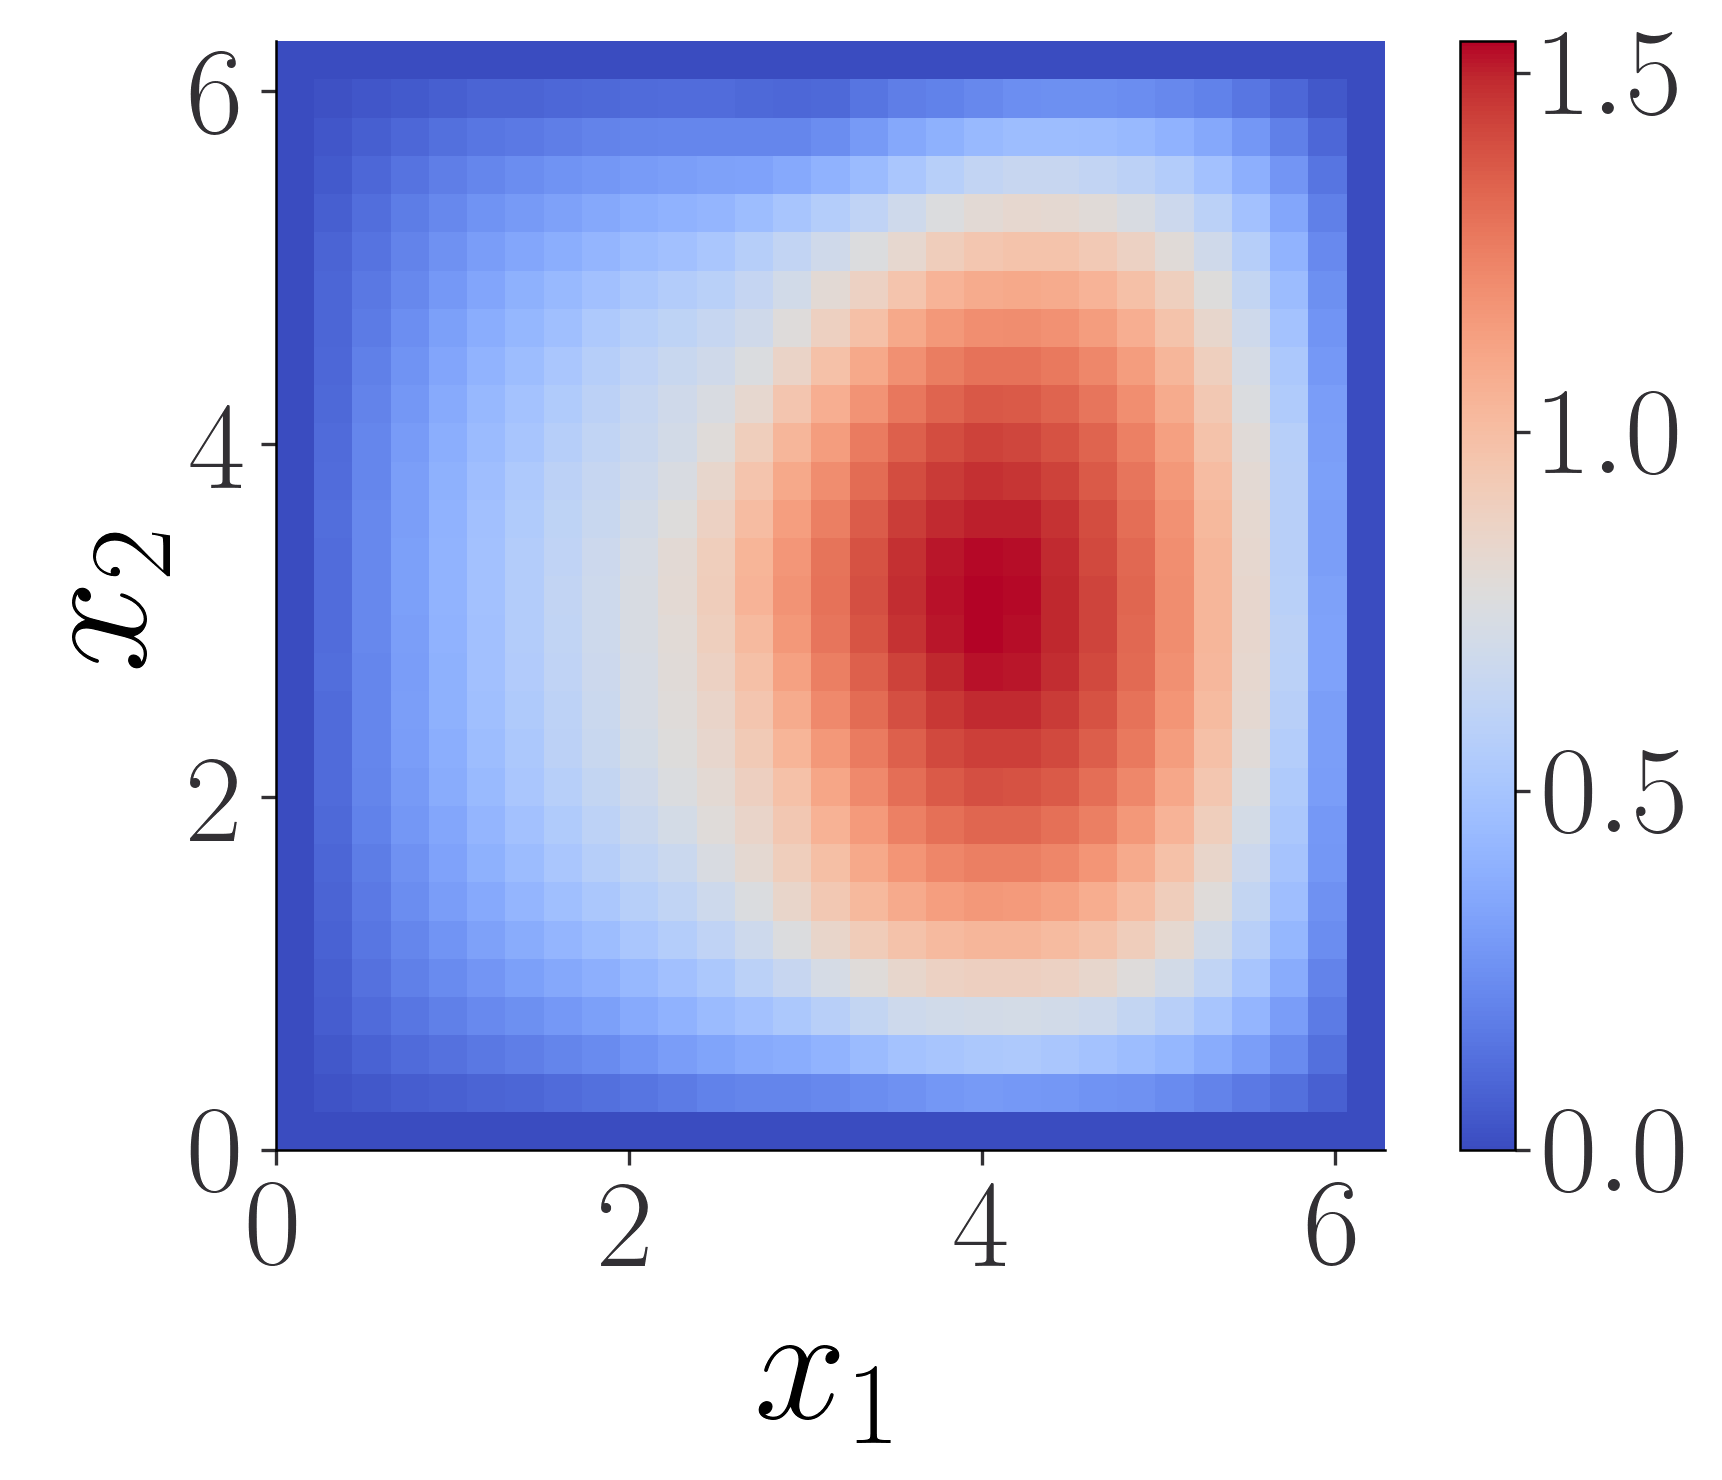

In [24]:
fig, ax = plt.subplots(1,1)
ax.set_xlabel(r'$x_1$')
#fig.suptitle(r'Input, Navier Stokes')
ax.set_ylabel(r'$x_2$')
s = ax.imshow(y_pred, extent=(0,2*np.pi,0,2*np.pi), origin = 'lower')
#ax.set_xticks([0, 2.5, 5])
c = fig.colorbar(s)
ax.set_xticks([0, 2, 4, 6])
#c.set_ticks([-0.05, 0, 0.05])
plt.savefig('PredictedDarcy.pdf',  bbox_inches = 'tight')

In [29]:
diff = np.sqrt((y_true - y_pred)**2)

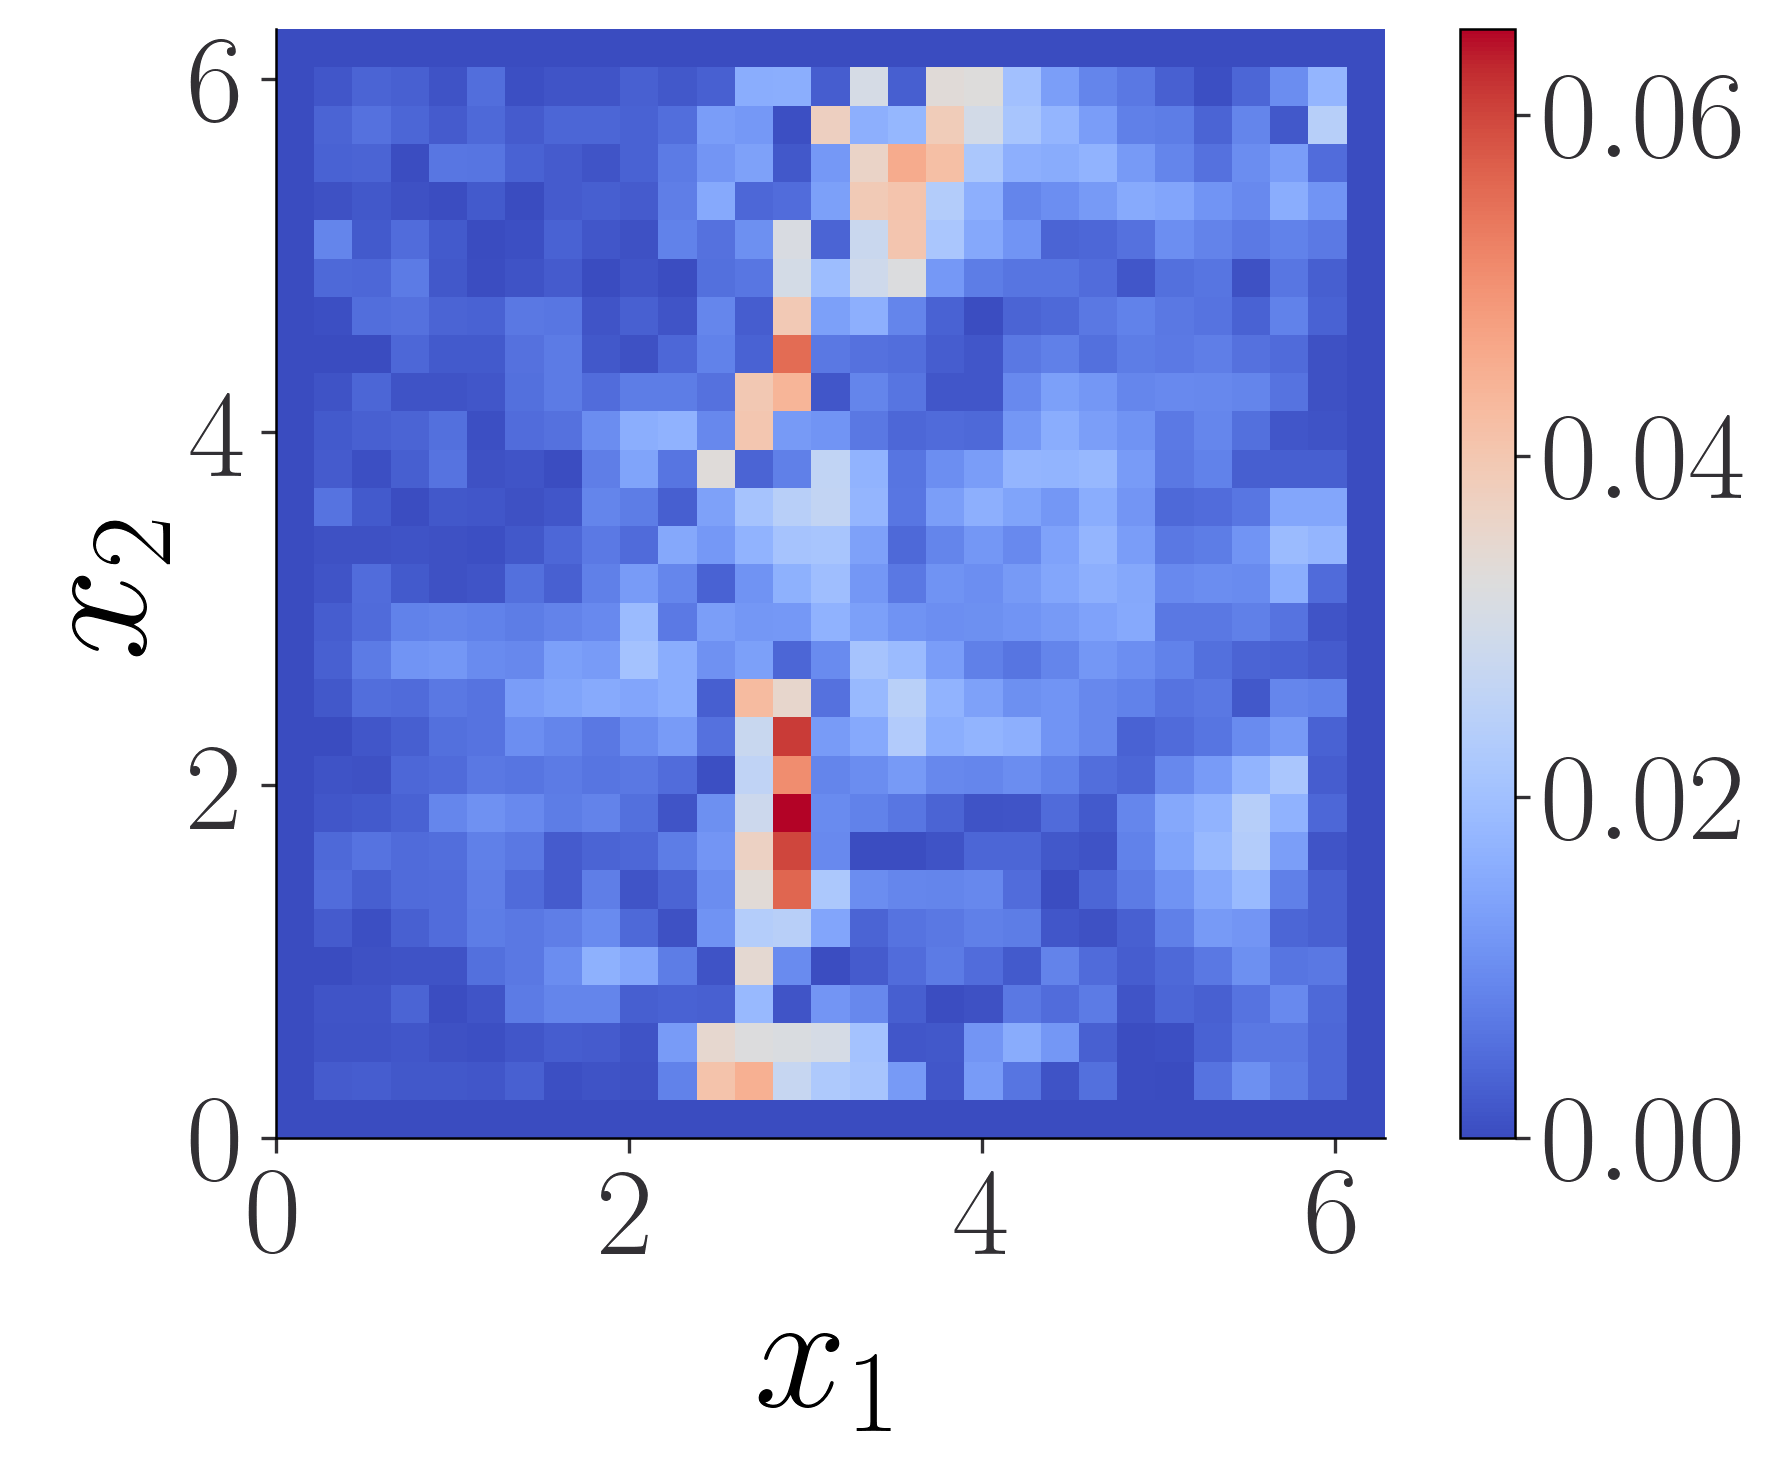

In [31]:
fig, ax = plt.subplots(1,1)
ax.set_xlabel(r'$x_1$')
#fig.suptitle(r'Input, Navier Stokes')
ax.set_ylabel(r'$x_2$')
s = ax.imshow(diff, extent=(0,2*np.pi,0,2*np.pi), origin = 'lower')
ax.set_xticks([0, 2, 4, 6])
c = fig.colorbar(s)
#c.set_ticks([0.1,0.3, 0.5])
plt.savefig('ErrorDarcy.pdf',  bbox_inches = 'tight')